In [10]:
import os
import sys

In [11]:
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt

In [5]:
import ase
from ase.io import cube
from ase.io import cif
import h5py
import pickle
import io
import json
import re

In [4]:


from IPython.display import display, HTML
from scipy.spatial import Delaunay
import plotly
from plotly.graph_objs import graph_objs as go
import ipywidgets as widgets
plotly.offline.init_notebook_mode(connected=True)
from plotly.offline import iplot

In [24]:
import pymatgen.core as mg
from pymatgen.io.cif import CifWriter
from pymatgen.io.cif import CifFile
from pymatgen.core.structure import Structure

In [8]:
import gudhi,gudhi.hera,gudhi.wasserstein,persim

In [15]:
inDir="Z:/data/diverse_metals"
os.chdir(inDir)

In [14]:
fName="DB0-m1_o2_o5_f0_pcu.cif"
#viz_mof_cif_v2(f"{inDir}/cifs/{fName}")

In [25]:
#struct=CifFile.from_file(f"{inDir}/cifs/{fName}")
struct=Structure.from_file(f"{inDir}/cifs/{fName}")

C:\Users\moore\anaconda3\lib\site-packages\pymatgen\io\cif.py:1167: UserWarning:

Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.



In [26]:
struct.distance_matrix

array([[ 0.        ,  9.67198973, 15.10533246, ..., 16.16250802,
         1.9405168 , 10.49145645],
       [ 9.67198973,  0.        , 17.57352408, ..., 15.52232943,
        10.50561936,  1.93719536],
       [15.10533246, 17.57352408,  0.        , ..., 10.49059351,
        13.21983794, 18.10649808],
       ...,
       [16.16250802, 15.52232943, 10.49059351, ...,  0.        ,
        16.7352372 , 13.71295422],
       [ 1.9405168 , 10.50561936, 13.21983794, ..., 16.7352372 ,
         0.        , 11.59341908],
       [10.49145645,  1.93719536, 18.10649808, ..., 13.71295422,
        11.59341908,  0.        ]])

In [ ]:
struct

In [ ]:
mg.io.cif

In [18]:
mg.__version__

'2023.1.9'

## Forking portions from Xiaoli's plotlyMOF.py

In [11]:

def read_cif_lattice_param(fname):
    cif_str = None
    with io.open(fname, "r", newline="\n") as cif:
        cif_str = cif.read().replace("(", "").replace(")", "")

    cif_list = cif_str.split("loop_")
    for cif_section in cif_list:
        if "_cell_length_a" in cif_section:
            a = float(cif_section.split("_cell_length_a")[1].split("\n")[0])
            b = float(cif_section.split("_cell_length_b")[1].split("\n")[0])
            c = float(cif_section.split("_cell_length_c")[1].split("\n")[0])

            alpha = float(cif_section.split("_cell_angle_alpha")[1].split("\n")[0])
            beta = float(cif_section.split("_cell_angle_beta")[1].split("\n")[0])
            gamma = float(cif_section.split("_cell_angle_gamma")[1].split("\n")[0])
            break
    return a, b, c, alpha, beta, gamma

def read_cif_xyz(fname):
    cif_str = None
    with io.open(fname, "r", newline="\n") as cif:
        cif_str = cif.read().replace("(", "").replace(")", "")
    cif_list = cif_str.split("loop_")
    for cif_section in cif_list:
        if "_atom_site_fract_x" in cif_section:
            #atom_lines = cif_section.split("\n")
            columns = list(re.findall(r".*_atom_.*\n", cif_section))
            df_str = cif_section.replace("".join(columns), "").strip()
            columns = [x.strip() for x in columns]
            return pd.read_csv(io.StringIO(df_str), names=columns, sep=r"\s+")
    return None

def read_cif_bond(fname):
    cif_str = None
    with io.open(fname, "r", newline="\n") as cif:
        cif_str = cif.read().replace("(", "").replace(")", "")
    cif_list = cif_str.split("loop_")
    for cif_section in cif_list:
        if "_geom_bond_atom_site_label_1" in cif_section:
            #bond_lines = cif_section.split("\n")
            columns = list(re.findall(r".*_geom_.*\n", cif_section))
            df_str = cif_section.replace("".join(columns), "").strip()
            columns = [x.strip() for x in columns]
            return pd.read_csv(io.StringIO(df_str), names=columns, sep=r"\s+")
    return None

def pairwise_distance_pbc(df1, df2, M):
    needed_cols = ["_atom_site_label", "_atom_site_type_symbol",
                   "_atom_site_fract_x", "_atom_site_fract_y", "_atom_site_fract_z"]
    xyz_cols = ["_atom_site_fract_x", "_atom_site_fract_y", "_atom_site_fract_z"]
    site_col = "_atom_site_label"
    np1_expand = df1.loc[:, needed_cols].to_numpy().repeat(len(df2), axis=0)
    np2_expand = np.tile(df2.loc[:, needed_cols].to_numpy(), (len(df1), 1))
    df1_expand = pd.DataFrame(np1_expand, columns=needed_cols)
    df2_expand = pd.DataFrame(np2_expand, columns=needed_cols)
    dxdydz = df1_expand.loc[:, xyz_cols] - df2_expand.loc[:, xyz_cols]
    dxdydz[dxdydz>0.5] -= 1
    dxdydz[dxdydz<-0.5] += 1
    dist2 = ((dxdydz @ M) * (dxdydz @ M)).sum(axis=1)
    sub_df = pd.DataFrame(np.array([df1_expand.loc[:, site_col].to_list(),
                                    df2_expand.loc[:, site_col].to_list(),
                                    dist2.to_list()]).T,
                          columns=["A", "B", "dist2"]).astype({"A": str,
                                                               "B": str,
                                                               "dist2": float})
    sub_df = sub_df.sort_values(by="dist2").reset_index(drop=True)
    return sub_df

def lat_param2vec(lat_param):
    a, b, c, alpha, beta, gamma = lat_param
    alpha_rad = alpha * np.pi / 180
    beta_rad = beta * np.pi / 180
    gamma_rad = gamma * np.pi / 180
    n2 = (np.cos(alpha_rad)-np.cos(gamma_rad)*np.cos(beta_rad))/np.sin(gamma_rad)
    M  = np.array([[a,                   0,                   0],
                   [b*np.cos(gamma_rad), b*np.sin(gamma_rad), 0],
                   [c*np.cos(beta_rad),  c*n2,                c*np.sqrt(np.sin(beta_rad)**2-n2**2)]])
    return M


In [12]:
def viz_mof_cif_v2(cif_name, fract_disp=np.array([0, 0, 0]), showbackground=False, tol=0.01, bond_dist_sqr_threshold=6):
    table_dict = {}
    # https://github.com/Bowserinator/Periodic-Table-JSON
    with io.open("PeriodicTableJSON.json", "rb") as f:
        table_dict = json.load(f)
    element_df = pd.DataFrame(table_dict["elements"])
    element_df["cpk-hex"] = element_df["cpk-hex"].fillna("0000ff")
    symbol2color = dict(zip(element_df["symbol"], element_df["cpk-hex"]))
    symbol2color["X"] = "0000ff"
    idx2symbol = dict(zip(element_df["number"], element_df["symbol"]))
    idx2symbol[0] = "X"

    _cif_name = cif_name
    #cif_str = None
    with io.open(cif_name, "r", newline="\n") as cif:
        cif_str = cif.read().replace("(", "").replace(")", "")
    cif_list = cif_str.split("loop_")
    for cif_section in cif_list:
        if "_symmetry_equiv_pos_as_xyz" in cif_section:
            if len(cif_section.split("_cell_")[0].split("_symmetry_equiv_pos_as_xyz")[1].strip().split("\n")) > 1:
                cif_name = cif_name.replace(".cif", "_P1.cif")
                CifWriter(mg.Structure.from_str(cif_str, fmt="cif"), refine_struct=False).write_file(cif_name)


    M = lat_param2vec(read_cif_lattice_param(cif_name))
    A, B, C = M
    atom_df = read_cif_xyz(cif_name)
    bond_df = read_cif_bond(cif_name)

    #bond_df = None
    Natoms = len(atom_df)
    atom_df.loc[:, ["_atom_site_fract_x",
                    "_atom_site_fract_y",
                    "_atom_site_fract_z"]] = (atom_df.loc[:, ["_atom_site_fract_x",
                                                              "_atom_site_fract_y",
                                                              "_atom_site_fract_z"]].values + fract_disp) % 1# - np.array([0.5, 0.5, 0.5])) % 1
    atom_df["x"] = None
    atom_df["y"] = None
    atom_df["z"] = None
    atom_df["_atom_site_label_prefix"] = atom_df["_atom_site_label"].apply(lambda x: re.findall(r"[A-Z]*[a-z]*", x)[0])
    atom_df["_atom_site_label_postfix"] = atom_df["_atom_site_label"].apply(lambda x: re.findall(r"[0-9]+", x)[0])


    error_atom_index = atom_df[atom_df["_atom_site_label_prefix"]!=atom_df["_atom_site_type_symbol"]].index
    atom_df.loc[error_atom_index, "_atom_site_label"] = atom_df.loc[error_atom_index, "_atom_site_type_symbol"].astype(str) + \
                                                        atom_df.loc[error_atom_index, "_atom_site_label_postfix"].astype(str)

    unique_elements = sorted(atom_df["_atom_site_type_symbol"].unique().tolist())
    natoms_per_element = {}
    atom_idx_offset = np.zeros(Natoms, dtype=int)
    atom_df.loc[:, "_atom_site_label_save"] = atom_df.loc[:, "_atom_site_label"]
    for element in unique_elements:
        selected_index = atom_df[atom_df["_atom_site_type_symbol"]==element].index
        natoms_per_element[element] = len(selected_index)
        atom_idx_offset[selected_index] = natoms_per_element[element]

        atom_df.loc[selected_index, "_atom_site_label_postfix"] = [x for x in range(1, len(selected_index)+1)]
        atom_df.loc[selected_index, "_atom_site_label"] = element + atom_df.loc[selected_index, "_atom_site_label_postfix"].astype(str)
    # label_map_dict = dict(zip(atom_df["_atom_site_label_save"].to_list() + atom_df["_atom_site_label"].to_list(),
    #                           atom_df["_atom_site_label"].to_list() + atom_df["_atom_site_label"].to_list()))
    label_map_dict = dict(zip(atom_df["_atom_site_label_save"].to_list(),
                          atom_df["_atom_site_label"].to_list()))
    for old_label_idx in range(0, len(atom_df["_atom_site_label"])):
        if atom_df.at[old_label_idx, "_atom_site_label"] not in label_map_dict:
            label_map_dict[atom_df.at[old_label_idx, "_atom_site_label"]] = atom_df.at[old_label_idx, "_atom_site_label"]
    if type(bond_df) != type(None):
        bond_df["_geom_bond_atom_site_label_1_save"] = bond_df["_geom_bond_atom_site_label_1"]
        bond_df["_geom_bond_atom_site_label_1"] = bond_df["_geom_bond_atom_site_label_1"].map(label_map_dict)
        bond_df["_geom_bond_atom_site_label_2_save"] = bond_df["_geom_bond_atom_site_label_2"]
        bond_df["_geom_bond_atom_site_label_2"] = bond_df["_geom_bond_atom_site_label_2"].map(label_map_dict)
        bond_df["_geom_bond_atom_site_label_1_prefix"] = bond_df["_geom_bond_atom_site_label_1"].apply(lambda x: re.findall(r"[A-Z]*[a-z]*", x)[0])
        bond_df["_geom_bond_atom_site_label_1_postfix"] = bond_df["_geom_bond_atom_site_label_1"].apply(lambda x: re.findall(r"[0-9]+", x)[0])
        bond_df["_geom_bond_atom_site_label_2_prefix"] = bond_df["_geom_bond_atom_site_label_2"].apply(lambda x: re.findall(r"[A-Z]*[a-z]*", x)[0])
        bond_df["_geom_bond_atom_site_label_2_postfix"] = bond_df["_geom_bond_atom_site_label_2"].apply(lambda x: re.findall(r"[0-9]+", x)[0])
        bond_df_atom_idx_offset1 = np.zeros(len(bond_df), dtype=int)
        bond_df_atom_idx_offset2 = np.zeros(len(bond_df), dtype=int)
        for element in unique_elements:
            bond_df_selected_index = bond_df[bond_df["_geom_bond_atom_site_label_1_prefix"]==element].index
            bond_df_atom_idx_offset1[bond_df_selected_index] = natoms_per_element[element]
            bond_df_selected_index = bond_df[bond_df["_geom_bond_atom_site_label_2_prefix"]==element].index
            bond_df_atom_idx_offset2[bond_df_selected_index] = natoms_per_element[element]
        bond_df_list = [bond_df.copy(deep=True)]

    atom_df["original_label"] = atom_df["_atom_site_label"].to_list()
    atom_df["periodic_image"] = "[0, 0, 0]"
    atom_df_list = [atom_df.copy(deep=True)]

    displacement_vectors = [[0,0,1], [0,0,-1],
                            [0,1,0], [0,-1,0],
                            [1,0,0], [-1,0,0],
                            [-1,-1,0], [-1,1,0], [1,-1,0], [1,1,0],
                            [-1,0,-1], [-1,0,1], [1,0,-1], [1,0,1],
                            [0,-1,-1], [0,-1,1], [0,1,-1], [0,1,1],
                            [-1,-1,-1], [-1,-1,1], [-1,1,-1], [1,-1,-1],
                            [-1,1,1], [1,-1,1], [1,1,-1], [1,1,1]]

    for disp_i in range(0, len(displacement_vectors)):
        disp = displacement_vectors[disp_i]
        if type(bond_df) != type(None):
            _bond_df = bond_df.copy(deep=True)
            _bond_df["_geom_bond_atom_site_label_1_postfix"] = ((disp_i + 1) * bond_df_atom_idx_offset1 + \
                                                                _bond_df["_geom_bond_atom_site_label_1_postfix"].astype(int)).astype(str)
            _bond_df["_geom_bond_atom_site_label_1"] = _bond_df["_geom_bond_atom_site_label_1_prefix"] + _bond_df["_geom_bond_atom_site_label_1_postfix"]
            _bond_df["_geom_bond_atom_site_label_2_postfix"] = ((disp_i + 1) * bond_df_atom_idx_offset2 + \
                                                                _bond_df["_geom_bond_atom_site_label_2_postfix"].astype(int)).astype(str)
            _bond_df["_geom_bond_atom_site_label_2"] = _bond_df["_geom_bond_atom_site_label_2_prefix"] + _bond_df["_geom_bond_atom_site_label_2_postfix"]
            bond_df_list.append(_bond_df)

        _atom_df = atom_df.copy(deep=True)
        _atom_df.loc[:, "periodic_image"] = str(disp)
        _atom_df.loc[:, ["_atom_site_fract_x",
                         "_atom_site_fract_y",
                         "_atom_site_fract_z"]] = _atom_df.loc[:, ["_atom_site_fract_x",
                                                                   "_atom_site_fract_y",
                                                                   "_atom_site_fract_z"]].values + np.array(disp)
        _atom_df["_atom_site_label_postfix"] = ((disp_i + 1) * atom_idx_offset + _atom_df["_atom_site_label_postfix"].astype(int)).astype(str)
        _atom_df["original_label"] = _atom_df["_atom_site_label"].to_list()
        _atom_df["_atom_site_label"] = _atom_df["_atom_site_type_symbol"] + _atom_df["_atom_site_label_postfix"]

        atom_df_list.append(_atom_df)

    atom_df = pd.concat(atom_df_list, axis=0).reset_index(drop=True)
    if type(bond_df) != type(None):
        bond_df = pd.concat(bond_df_list, axis=0).reset_index(drop=True)

    atom_df.loc[:, ["x", "y", "z"]] = atom_df.loc[:, ["_atom_site_fract_x",
                                                      "_atom_site_fract_y",
                                                      "_atom_site_fract_z"]].values @ M
    unit_cell_expansion_offset = 2 # Angstrom
    critical_points = [np.array([-1, -1, -1])*unit_cell_expansion_offset,
                       np.array([1, -1, -1])*unit_cell_expansion_offset + A,
                       np.array([-1, 1, -1])*unit_cell_expansion_offset + B,
                       np.array([-1, -1, 1])*unit_cell_expansion_offset + C,
                       np.array([1, 1, -1])*unit_cell_expansion_offset + A + B,
                       np.array([-1, 1, 1])*unit_cell_expansion_offset + B + C,
                       np.array([1, -1, 1])*unit_cell_expansion_offset + A + C,
                       np.array([1, 1, 1])*unit_cell_expansion_offset + A + B + C]
    hull = Delaunay(critical_points)
    #tol=0.01

    isInHull = hull.find_simplex(atom_df.loc[:, ["x", "y", "z"]].values)>=-tol
    atom_df = atom_df[isInHull].copy(deep=True)
    atom_df.loc[:, ["x", "y", "z"]] = atom_df.loc[:, ["_atom_site_fract_x",
                                                      "_atom_site_fract_y",
                                                      "_atom_site_fract_z"]].values @ M

    bond_scatter = []

    if type(bond_df) != type(None):
        bond_df["atom1"] = None
        bond_df["atom2"] = None
        bond_df["atom1"] = bond_df["_geom_bond_atom_site_label_1"].map(dict(zip(atom_df["_atom_site_label"], atom_df.index)))
        bond_df["atom2"] = bond_df["_geom_bond_atom_site_label_2"].map(dict(zip(atom_df["_atom_site_label"], atom_df.index)))
        bond_df = bond_df.dropna()
        bond_df["atom1"] = bond_df["atom1"].astype(int)
        bond_df["atom2"] = bond_df["atom2"].astype(int)
        bond_df["dist_sqr"] = [np.sum((atom_df.loc[bond_df.at[i, "atom1"].astype(int), ["x", "y", "z"]].values - \
                                       atom_df.loc[bond_df.at[i, "atom2"].astype(int), ["x", "y", "z"]].values) ** 2) for i in bond_df.index]

        for i in bond_df.index:
            orig_label1 = atom_df.at[bond_df.at[i, "atom1"], "original_label"]
            affiliated_atoms1 = atom_df[atom_df["original_label"]==orig_label1].copy(deep=True).reset_index(drop=True)
            orig_label2 = atom_df.at[bond_df.at[i, "atom2"], "original_label"]
            affiliated_atoms2 = atom_df[atom_df["original_label"]==orig_label2].copy(deep=True).reset_index(drop=True)
            possible_bonds = pd.concat([pd.DataFrame(np.repeat(affiliated_atoms1.values, len(affiliated_atoms2), axis=0), columns=affiliated_atoms1.columns + "_1"),
                                        pd.DataFrame(np.tile(affiliated_atoms2.values, (len(affiliated_atoms1), 1)), columns=affiliated_atoms2.columns + "_2")], axis=1)
            possible_bonds["dist_sqr"] = np.sum((possible_bonds.loc[:, ["x_1", "y_1", "z_1"]].values - possible_bonds.loc[:, ["x_2", "y_2", "z_2"]].values) ** 2, axis=1)
            possible_bonds = possible_bonds[possible_bonds["dist_sqr"]<bond_dist_sqr_threshold]
            for bond_idx in possible_bonds.index:
                bond_scatter.append(
                    go.Scatter3d(
                        x=[possible_bonds.at[bond_idx, "x_1"], possible_bonds.at[bond_idx, "x_2"]],
                        y=[possible_bonds.at[bond_idx, "y_1"], possible_bonds.at[bond_idx, "y_2"]],
                        z=[possible_bonds.at[bond_idx, "z_1"], possible_bonds.at[bond_idx, "z_2"]],
                        mode="lines",
                        line=dict(
                            color='rgba(100, 100, 255, 0.5)',
                            width=5,
                        ),
                        showlegend=False,
                        hoverinfo='skip')
                )

    unit_cell = [[np.array([0, 0, 0]), A], [np.array([0, 0, 0]), B], [np.array([0, 0, 0]), C],
                 [A, A+B], [A, A+C], [B, B+A],
                 [B, B+C], [C, C+A], [C, C+B],
                 [A+B, A+B+C], [B+C, A+B+C], [A+C, A+B+C]]
    unit_cell_color = ["rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)",
                       "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)",
                       "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)",
                       "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)", "rgba(255, 255, 0, 1)"]

    # XYZ arrows
    axis_length = 0.5
    V_diag = 0.25 * (A + B + C)
    x_start = -V_diag[0]
    y_start = -V_diag[1]
    z_start = -V_diag[2]
    x_end1 = (axis_length * A - V_diag)[0]
    y_end1 = (axis_length * A - V_diag)[1]
    z_end1 = (axis_length * A - V_diag)[2]
    x_end2 = (axis_length * B - V_diag)[0]
    y_end2 = (axis_length * B - V_diag)[1]
    z_end2 = (axis_length * B - V_diag)[2]
    x_end3 = (axis_length * C - V_diag)[0]
    y_end3 = (axis_length * C - V_diag)[1]
    z_end3 = (axis_length * C - V_diag)[2]
    arrows = [
        go.Scatter3d(x=[x_start, x_end1],
                     y=[y_start, y_end1],
                     z=[z_start, z_end1],
                     mode="lines+text",
                     text=["", "A"],
                     line=dict(
                         color='rgba(255, 0, 0, 1)',
                         width=5,
                     ),
                     textfont=dict(
                         color='rgba(255, 0, 0, 1)',
                         size=20,
                     ),
                     showlegend=False,
                     hoverinfo='skip',
        ),
        go.Scatter3d(x=[x_start, x_end2],
                     y=[y_start, y_end2],
                     z=[z_start, z_end2],
                     mode="lines+text",
                     text=["", "B"],
                     line=dict(
                         color='rgba(0, 255, 0, 1)',
                         width=5,
                     ),
                     textfont=dict(
                         color='rgba(0, 255, 0, 1)',
                         size=20,
                     ),
                     showlegend=False,
                     hoverinfo='skip',
        ),
        go.Scatter3d(x=[x_start, x_end3],
                     y=[y_start, y_end3],
                     z=[z_start, z_end3],
                     mode="lines+text",
                     text=["", "C"],
                     line=dict(
                         color='rgba(0, 0, 255, 1)',
                         width=5,
                     ),
                     textfont=dict(
                         color='rgba(0, 0, 255, 1)',
                         size=20,
                     ),
                     showlegend=False,
                     hoverinfo='skip',
        ),
    ]
    atom_df["color"] = "#" + atom_df["_atom_site_type_symbol"].map(symbol2color)
    data=[go.Scatter3d(x=atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "x"],
                       y=atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "y"],
                       z=atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "z"],
                       text=atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "_atom_site_type_symbol"] + "<br>" + \
                            atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "_atom_site_label"] + "<br>" + \
                            atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "periodic_image"] + "<br>was " + \
                            atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "original_label"],
                       mode='markers',
                       showlegend=True,
                       name=k,
                       marker=dict(
                           color=atom_df[atom_df["_atom_site_type_symbol"]==k].loc[:, "color"],
                           size=10,
                           opacity=1.0,
                       )) for k in unique_elements] + \
                       bond_scatter + [go.Scatter3d(x=np.array(unit_cell[i]).T[0],
                                                    y=np.array(unit_cell[i]).T[1],
                                                    z=np.array(unit_cell[i]).T[2],
                                                    mode="lines",
                                                    line=dict(
                                                        color=unit_cell_color[i],
                                                        width=2,
                                                    ),
                                                    showlegend=False,
                                                    hoverinfo='skip') for i in range(0, len(unit_cell))] + arrows

    xyzmin = min([atom_df["x"].min(), atom_df["y"].min(), atom_df["z"].min(), np.array(unit_cell).min(), (0-V_diag).min()])
    xyzmax = max([atom_df["x"].max(), atom_df["y"].max(), atom_df["z"].max(), np.array(unit_cell).max(), (0-V_diag).max()])
    DeltaX = xyzmax - xyzmin
    padding_xyz = DeltaX * 0.05
    fig = go.Figure(data=data)
    annotation_list = []
    fig.update_layout(
        scene = dict(
            annotations=annotation_list,
            xaxis = dict(nticks=10, range=[xyzmin-padding_xyz,xyzmax+padding_xyz],
                         backgroundcolor="rgba(80, 70, 70, 0.5)",
                         gridcolor="white",
                         showbackground=showbackground,
                         showgrid=False,
                         zeroline=False,
                         showticklabels=False,
                         visible=False,
                         #zerolinecolor="white",
                        ),
            yaxis = dict(nticks=10, range=[xyzmin-padding_xyz, xyzmax+padding_xyz],
                         backgroundcolor="rgba(70, 80, 70, 0.5)",
                         gridcolor="white",
                         showbackground=showbackground,
                         showgrid=False,
                         zeroline=False,
                         showticklabels=False,
                         visible=False,
                         #zerolinecolor="white",
                        ),
            zaxis = dict(nticks=10, range=[xyzmin-padding_xyz, xyzmax+padding_xyz],
                         backgroundcolor="rgba(70, 70, 80, 0.5)",
                         gridcolor="white",
                         showbackground=showbackground,
                         showgrid=False,
                         zeroline=False,
                         showticklabels=False,
                         visible=False,
                         #zerolinecolor="white",
                        ),
        ),
        width=1200,
        height=1200,
        margin=dict(r=10, l=10, b=10, t=10),
        showlegend=True)
    fig.update_layout(scene_aspectmode='cube',
                      paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(
        font_color="rgba(150,150,150,1)",
        title_font_color="rgba(150,150,150,1)",
        legend_title_font_color="rgba(150,150,150,1)",
    )

    if _cif_name != cif_name:
        os.remove(cif_name)

    return fig



In [13]:
with io.open("PeriodicTableJSON.json", "rb") as f:
    table_dict = json.load(f)
element_df = pd.DataFrame(table_dict["elements"])
element_df["cpk-hex"] = element_df["cpk-hex"].fillna("0000ff")
symbol2color = dict(zip(element_df["symbol"], element_df["cpk-hex"]))
symbol2color["X"] = "0000ff"
idx2symbol = dict(zip(element_df["number"], element_df["symbol"]))
idx2symbol[0] = "X"


In [14]:
cif_name=f"{inDir}/cifs/{fName}"
atom_df = read_cif_xyz(cif_name)

In [15]:
atom_df

,_atom_site_label,_atom_site_type_symbol,_atom_site_description,_atom_site_fract_x,_atom_site_fract_y,_atom_site_fract_z,_atom_type_partial_charge
0,Zn1,Zn,Zn3+2,0.066392,0.499185,0.299719,0.0
1,Zn2,Zn,Zn3+2,0.933632,0.499285,0.700310,0.0
2,Zn3,Zn,Zn3+2,0.501835,0.935949,0.300607,0.0
3,Zn4,Zn,Zn3+2,0.497921,0.065995,0.701914,0.0
4,Zn5,Zn,Zn3+2,0.935967,0.499356,0.298470,0.0
...,...,...,...,...,...,...,...
255,C124,C,C_R,0.353425,0.148402,0.248500,0.0
256,C125,C,C_R,0.146734,0.648708,0.748548,0.0
257,C126,C,C_R,0.854183,0.350921,0.247680,0.0
258,C127,C,C_R,0.348879,0.147227,0.751622,0.0


In [16]:
fract_disp=np.array([0, 0, 0])

showbackground=False
tol=0.01
bond_dist_sqr_threshold=6

def grabAtomDF(cif_name, fract_disp=np.array([0, 0, 0]), showbackground=False, tol=0.01, bond_dist_sqr_threshold=6):



    with io.open("PeriodicTableJSON.json", "rb") as f:
        table_dict = json.load(f)
    element_df = pd.DataFrame(table_dict["elements"])
    element_df["cpk-hex"] = element_df["cpk-hex"].fillna("0000ff")
    symbol2color = dict(zip(element_df["symbol"], element_df["cpk-hex"]))
    symbol2color["X"] = "0000ff"
    idx2symbol = dict(zip(element_df["number"], element_df["symbol"]))
    idx2symbol[0] = "X"

    _cif_name = cif_name
    #cif_str = None
    with io.open(cif_name, "r", newline="\n") as cif:
        cif_str = cif.read().replace("(", "").replace(")", "")
    cif_list = cif_str.split("loop_")
    for cif_section in cif_list:
        if "_symmetry_equiv_pos_as_xyz" in cif_section:
            if len(cif_section.split("_cell_")[0].split("_symmetry_equiv_pos_as_xyz")[1].strip().split("\n")) > 1:
                cif_name = cif_name.replace(".cif", "_P1.cif")
                CifWriter(mg.Structure.from_str(cif_str, fmt="cif"), refine_struct=False).write_file(cif_name)


    M = lat_param2vec(read_cif_lattice_param(cif_name))
    A, B, C = M
    atom_df = read_cif_xyz(cif_name)
    bond_df = read_cif_bond(cif_name)

    #bond_df = None
    Natoms = len(atom_df)
    atom_df.loc[:, ["_atom_site_fract_x",
                    "_atom_site_fract_y",
                    "_atom_site_fract_z"]] = (atom_df.loc[:, ["_atom_site_fract_x",
                                                              "_atom_site_fract_y",
                                                              "_atom_site_fract_z"]].values + fract_disp) % 1# - np.array([0.5, 0.5, 0.5])) % 1
    atom_df["x"] = None
    atom_df["y"] = None
    atom_df["z"] = None
    atom_df["_atom_site_label_prefix"] = atom_df["_atom_site_label"].apply(lambda x: re.findall(r"[A-Z]*[a-z]*", x)[0])
    atom_df["_atom_site_label_postfix"] = atom_df["_atom_site_label"].apply(lambda x: re.findall(r"[0-9]+", x)[0])


    error_atom_index = atom_df[atom_df["_atom_site_label_prefix"]!=atom_df["_atom_site_type_symbol"]].index
    atom_df.loc[error_atom_index, "_atom_site_label"] = atom_df.loc[error_atom_index, "_atom_site_type_symbol"].astype(str) + \
                                                        atom_df.loc[error_atom_index, "_atom_site_label_postfix"].astype(str)

    unique_elements = sorted(atom_df["_atom_site_type_symbol"].unique().tolist())
    natoms_per_element = {}
    atom_idx_offset = np.zeros(Natoms, dtype=int)
    atom_df.loc[:, "_atom_site_label_save"] = atom_df.loc[:, "_atom_site_label"]
    for element in unique_elements:
        selected_index = atom_df[atom_df["_atom_site_type_symbol"]==element].index
        natoms_per_element[element] = len(selected_index)
        atom_idx_offset[selected_index] = natoms_per_element[element]

        atom_df.loc[selected_index, "_atom_site_label_postfix"] = [x for x in range(1, len(selected_index)+1)]
        atom_df.loc[selected_index, "_atom_site_label"] = element + atom_df.loc[selected_index, "_atom_site_label_postfix"].astype(str)
    # label_map_dict = dict(zip(atom_df["_atom_site_label_save"].to_list() + atom_df["_atom_site_label"].to_list(),
    #                           atom_df["_atom_site_label"].to_list() + atom_df["_atom_site_label"].to_list()))
    label_map_dict = dict(zip(atom_df["_atom_site_label_save"].to_list(),
                          atom_df["_atom_site_label"].to_list()))
    for old_label_idx in range(0, len(atom_df["_atom_site_label"])):
        if atom_df.at[old_label_idx, "_atom_site_label"] not in label_map_dict:
            label_map_dict[atom_df.at[old_label_idx, "_atom_site_label"]] = atom_df.at[old_label_idx, "_atom_site_label"]
    if type(bond_df) != type(None):
        bond_df["_geom_bond_atom_site_label_1_save"] = bond_df["_geom_bond_atom_site_label_1"]
        bond_df["_geom_bond_atom_site_label_1"] = bond_df["_geom_bond_atom_site_label_1"].map(label_map_dict)
        bond_df["_geom_bond_atom_site_label_2_save"] = bond_df["_geom_bond_atom_site_label_2"]
        bond_df["_geom_bond_atom_site_label_2"] = bond_df["_geom_bond_atom_site_label_2"].map(label_map_dict)
        bond_df["_geom_bond_atom_site_label_1_prefix"] = bond_df["_geom_bond_atom_site_label_1"].apply(lambda x: re.findall(r"[A-Z]*[a-z]*", x)[0])
        bond_df["_geom_bond_atom_site_label_1_postfix"] = bond_df["_geom_bond_atom_site_label_1"].apply(lambda x: re.findall(r"[0-9]+", x)[0])
        bond_df["_geom_bond_atom_site_label_2_prefix"] = bond_df["_geom_bond_atom_site_label_2"].apply(lambda x: re.findall(r"[A-Z]*[a-z]*", x)[0])
        bond_df["_geom_bond_atom_site_label_2_postfix"] = bond_df["_geom_bond_atom_site_label_2"].apply(lambda x: re.findall(r"[0-9]+", x)[0])
        bond_df_atom_idx_offset1 = np.zeros(len(bond_df), dtype=int)
        bond_df_atom_idx_offset2 = np.zeros(len(bond_df), dtype=int)
        for element in unique_elements:
            bond_df_selected_index = bond_df[bond_df["_geom_bond_atom_site_label_1_prefix"]==element].index
            bond_df_atom_idx_offset1[bond_df_selected_index] = natoms_per_element[element]
            bond_df_selected_index = bond_df[bond_df["_geom_bond_atom_site_label_2_prefix"]==element].index
            bond_df_atom_idx_offset2[bond_df_selected_index] = natoms_per_element[element]
        bond_df_list = [bond_df.copy(deep=True)]

    atom_df["original_label"] = atom_df["_atom_site_label"].to_list()
    atom_df["periodic_image"] = "[0, 0, 0]"
    atom_df_list = [atom_df.copy(deep=True)]

    displacement_vectors = [[0,0,1], [0,0,-1],
                            [0,1,0], [0,-1,0],
                            [1,0,0], [-1,0,0],
                            [-1,-1,0], [-1,1,0], [1,-1,0], [1,1,0],
                            [-1,0,-1], [-1,0,1], [1,0,-1], [1,0,1],
                            [0,-1,-1], [0,-1,1], [0,1,-1], [0,1,1],
                            [-1,-1,-1], [-1,-1,1], [-1,1,-1], [1,-1,-1],
                            [-1,1,1], [1,-1,1], [1,1,-1], [1,1,1]]

    for disp_i in range(0, len(displacement_vectors)):
        disp = displacement_vectors[disp_i]
        if type(bond_df) != type(None):
            _bond_df = bond_df.copy(deep=True)
            _bond_df["_geom_bond_atom_site_label_1_postfix"] = ((disp_i + 1) * bond_df_atom_idx_offset1 + \
                                                                _bond_df["_geom_bond_atom_site_label_1_postfix"].astype(int)).astype(str)
            _bond_df["_geom_bond_atom_site_label_1"] = _bond_df["_geom_bond_atom_site_label_1_prefix"] + _bond_df["_geom_bond_atom_site_label_1_postfix"]
            _bond_df["_geom_bond_atom_site_label_2_postfix"] = ((disp_i + 1) * bond_df_atom_idx_offset2 + \
                                                                _bond_df["_geom_bond_atom_site_label_2_postfix"].astype(int)).astype(str)
            _bond_df["_geom_bond_atom_site_label_2"] = _bond_df["_geom_bond_atom_site_label_2_prefix"] + _bond_df["_geom_bond_atom_site_label_2_postfix"]
            bond_df_list.append(_bond_df)

        _atom_df = atom_df.copy(deep=True)
        _atom_df.loc[:, "periodic_image"] = str(disp)
        _atom_df.loc[:, ["_atom_site_fract_x",
                         "_atom_site_fract_y",
                         "_atom_site_fract_z"]] = _atom_df.loc[:, ["_atom_site_fract_x",
                                                                   "_atom_site_fract_y",
                                                                   "_atom_site_fract_z"]].values + np.array(disp)
        _atom_df["_atom_site_label_postfix"] = ((disp_i + 1) * atom_idx_offset + _atom_df["_atom_site_label_postfix"].astype(int)).astype(str)
        _atom_df["original_label"] = _atom_df["_atom_site_label"].to_list()
        _atom_df["_atom_site_label"] = _atom_df["_atom_site_type_symbol"] + _atom_df["_atom_site_label_postfix"]

        atom_df_list.append(_atom_df)

    atom_df = pd.concat(atom_df_list, axis=0).reset_index(drop=True)
    if type(bond_df) != type(None):
        bond_df = pd.concat(bond_df_list, axis=0).reset_index(drop=True)

    atom_df.loc[:, ["x", "y", "z"]] = atom_df.loc[:, ["_atom_site_fract_x",
                                                      "_atom_site_fract_y",
                                                      "_atom_site_fract_z"]].values @ M
    unit_cell_expansion_offset = 2 # Angstrom
    critical_points = [np.array([-1, -1, -1])*unit_cell_expansion_offset,
                       np.array([1, -1, -1])*unit_cell_expansion_offset + A,
                       np.array([-1, 1, -1])*unit_cell_expansion_offset + B,
                       np.array([-1, -1, 1])*unit_cell_expansion_offset + C,
                       np.array([1, 1, -1])*unit_cell_expansion_offset + A + B,
                       np.array([-1, 1, 1])*unit_cell_expansion_offset + B + C,
                       np.array([1, -1, 1])*unit_cell_expansion_offset + A + C,
                       np.array([1, 1, 1])*unit_cell_expansion_offset + A + B + C]
    hull = Delaunay(critical_points)
    #tol=0.01

    isInHull = hull.find_simplex(atom_df.loc[:, ["x", "y", "z"]].values)>=-tol
    atom_df = atom_df[isInHull].copy(deep=True)
    atom_df.loc[:, ["x", "y", "z"]] = atom_df.loc[:, ["_atom_site_fract_x",
                                                      "_atom_site_fract_y",
                                                      "_atom_site_fract_z"]].values @ M
    return atom_df

In [ ]:
atom_df

In [ ]:
atom_df.loc[:, ["x", "y", "z"]].to_csv()

In [ ]:
try:
    os.mkdir(f"{inDir}/cifPointClouds")
except:
    pass

try:
    os.mkdir(f"{inDir}/cifPointClouds/total")
except:
    pass

exploredAtoms=set()
fName="DB0-m1_o2_o5_f0_pcu.cif"
cif_name=f"{inDir}/cifs/{fName}"
atom_df = grabAtomDF(cif_name)

atom_df.loc[:, ["x", "y", "z"]].to_csv(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv",index=False)

for a in set(atom_df['_atom_site_label_prefix']):
    if a not in exploredAtoms:
        exploredAtoms.add(a)
        try:
            os.mkdir(f"{inDir}/cifPointClouds/{a}")
        except:
            pass
        try:
            subXYZ=atom_df[atom_df['_atom_site_label_prefix'] == a]
            subXYZ.loc[:, ["x", "y", "z"]].to_csv(f"{inDir}/cifPointClouds/{a}/{fName[:-3]}csv",index=False)
        except:
            print(f"error with atom lab {a} in {fName} !!")

In [9]:
df=pd.read_csv(f"{inDir}/post-combustion-vsa-2-clean.csv",index_col=0)


# grab 4 bins for each, trP% of samples within regions
##
## workingCap: [0-1,1-2,2-4,4-]
## selectivity: [0-50,50-200,200-400,400-]
trP=.70
totalLen=len(df['selectivity'])
regVars=['selectivity','mmol/g_working_capacity']
bounds={"selectivity":[(0,50),(50,200),(200,400),(400,)],"mmol/g_working_capacity":[(0,1),(1,2),(2,4),(4,)]}

indexBounds={k:[] for k in bounds.keys()} #upper index for

for k in regVars:
    j=0
    bj=0
    for index,row in df.sort_values(by=[k]).iterrows():
        if bj>=len(bounds[k])-1:
            break
        elif row[k]>bounds[k][bj][1]:
            indexBounds[k].append(j)
            bj+=1
        j+=1

In [8]:
indexBounds['selectivity']

[7197, 11351, 12150]

In [ ]:
indexBounds['sel']

In [46]:
#seed, then random indices up to

np.random.seed(42)
testBins={k:[] for k in bounds.keys()}
for k in bounds.keys():
    j=0
    testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[:indexBounds[k][j]],size=round((1-trP)*indexBounds[k][j]),replace=False)))
    for j in range(1,len(indexBounds[k])):
        testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[indexBounds[k][j-1]:indexBounds[k][j]],size=round((1-trP)*(indexBounds[k][j]-indexBounds[k][j-1])),replace=False)))
    testBins[k].append(list(np.random.choice(df.sort_values(by=[k]).index[indexBounds[k][-1]:],size=round((1-trP)*(totalLen-indexBounds[k][-1])),replace=False)))



trainBins={k:[] for k in bounds.keys()}
for k in bounds.keys():
    j=0
    trainBins[k].append(list(set(df.sort_values(by=[k]).index[:indexBounds[k][j]])-set(testBins[k][j])))
    for j in range(1,len(indexBounds[k])):
        trainBins[k].append(list(set(df.sort_values(by=[k]).index[indexBounds[k][j-1]:indexBounds[k][j]])-set(testBins[k][j])))
    trainBins[k].append(list(set(df.sort_values(by=[k]).index[indexBounds[k][-1]:])-set(testBins[k][-1])))


#  testBins["selectivity"] -> list of sampled bins along selectivity bounds
#testBins['selectivity'][0] selects lowest selective MOFS sample <-> 4 bins, {k:{"low":[MOFIDs for low selectivity],"med"...,"high","superHigh"}

In [47]:
testBins["selectivity"][3] # good mof sample

['DB12-SEHZUB_clean',
 'DB12-QIWDOR_freeONLY',
 'DB12-FIPWOS_freeONLY',
 'DB12-LOKPEG_freeONLY',
 'DB12-KIDDOS_clean',
 'DB12-ETEMIB_clean',
 'DB12-EKIGOW_freeONLY',
 'DB12-OTOVAW_clean',
 'DB12-CODGAE_freeONLY',
 'DB12-VEHNED_clean',
 'DB12-HIZQEN_clean',
 'DB12-DEFRIR_clean',
 'DB12-MUVJIX_clean',
 'DB12-WEMFOL_freeONLY',
 'DB12-NEYZAU_clean']

In [48]:
testBins["selectivity"][0]

['DB0-m3_o10_o12_f0_pcu.sym.19',
 'DB7-ddmof_5103',
 'DB0-m3_o21_o27_f0_pcu.sym.111',
 'DB14-avemaq_P1_H',
 'DB0-m2_o13_o27_f0_pcu.sym.114',
 'DB12-c5cc10203k_c5cc10203k2_freeONLY',
 'DB0-m3_o10_o27_f0_pcu.sym.57',
 'DB5-hypotheticalMOF_5036721_3_1_1_18_24_3',
 'DB0-m2_o24_o27_f0_pcu.sym.15',
 'DB5-hypotheticalMOF_3001071_0_0_1_34_34_11',
 'DB0-m3_o11_o22_f0_pcu.sym.65',
 'DB12-CAKXOD_clean',
 'DB0-m3_o11_o24_f0_pcu.sym.21',
 'DB5-hypotheticalMOF_5015968_1_1_0_3_8_0',
 'DB5-hypotheticalMOF_5053407_1_0_1_27_3_5',
 'DB0-m3_o150_o22_f0_fsc.sym.4',
 'DB12-MAQZOV_clean',
 'DB5-hypotheticalMOF_5061870_0_0_2_18_24_14',
 'DB0-m3_o11_o24_f0_pcu.sym.7',
 'DB0-m2_o13_o16_f0_pcu.sym.64',
 'DB5-hypotheticalMOF_32203_1_0_2_11_2_6',
 'DB0-m2_o18_o22_f0_pcu.sym.113',
 'DB0-m3_o19_o23_f0_pcu.sym.7',
 'DB12-GUNFAW01_neutral',
 'DB0-m2_o18_o21_f0_pcu.sym.81',
 'DB0-m2_o8_o22_f0_pcu.sym.10',
 'DB0-m3_o155_o151_f0_fsc.sym.13',
 'DB5-hypotheticalMOF_5051575_1_0_1_27_21_8',
 'DB15-pcu_N123_E202_opt',
 'DB12-

In [66]:
[j for j in testBins["mmol/g_working_capacity"][3] if j not in testBins["selectivity"][3]]

['DB15-pcu_N139_E13_opt',
 'DB15-pcu_N65_E18_opt',
 'DB1-Cu2O8-AZO_A-fum_A_No201',
 'DB12-BUWMEN_clean',
 'DB1-Zn2O8-fum_A-irmof20_A_No142',
 'DB12-XAVQIU_clean',
 'DB12-SERWAP_freeONLY',
 'DB12-SOBZEQ_clean',
 'DB12-LONWIW_clean',
 'DB1-Zn2O8N2-irmof8_A-TED_A_No11',
 'DB5-hypotheticalMOF_19078_2_1_1_24_17_5',
 'DB0-m3_o16_o84_f0_fsc',
 'DB15-pcu_N65_E37_opt',
 'DB12-AFUPEX_clean',
 'DB12-VETTOE_clean',
 'DB5-hypotheticalMOF_5074380_0_0_2_23_1_7',
 'DB5-hypotheticalMOF_5040372_1_1_1_15_16_4',
 'DB12-YUFLOC_clean',
 'DB12-QIWPET_clean',
 'DB12-XESKAJ_clean',
 'DB0-m2_o10_o28_f0_pcu.sym.52',
 'DB0-m18_o15_o77_f0_fsc',
 'DB12-XEKCAT01_clean',
 'DB12-PAPVAF_clean',
 'DB5-hypotheticalMOF_35541_0_0_2_14_7_5',
 'DB12-BUWMIR_clean',
 'DB12-BEXSEE_clean',
 'DB15-pcu_N139_E120_opt',
 'DB5-hypotheticalMOF_35842_0_0_2_14_1_2',
 'DB12-QUQFIS_clean',
 'DB1-Zn2O8N2-irmof20_A-irmof7_A_No372',
 'DB12-FIFNUE_clean',
 'DB12-XIBZUF_clean',
 'DB5-hypotheticalMOF_5074449_0_0_2_23_10_12',
 'DB0-m15_o10_o139_

In [63]:
list(testBins.keys())

['selectivity', 'mmol/g_working_capacity']

# CIF2XYZ CSV

In [56]:
exploredAtoms=set(os.listdir(f"{inDir}/cifPointClouds"))-{"total"}
for fName in ["DB0-m2_o13_o27_f0_pcu.sym.114"]:
    fName+=".cif"
    cif_name=f"{inDir}/cifs/{fName}"
    atom_df = grabAtomDF(cif_name)

    atom_df.loc[:, ["x", "y", "z"]].to_csv(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv",index=False)

    for a in set(atom_df['_atom_site_label_prefix']):
        if a not in exploredAtoms:
            exploredAtoms.add(a)
            try:
                os.mkdir(f"{inDir}/cifPointClouds/{a}")
            except:
                pass
        try:
            subXYZ=atom_df[atom_df['_atom_site_label_prefix'] == a]
            subXYZ.loc[:, ["x", "y", "z"]].to_csv(f"{inDir}/cifPointClouds/{a}/{fName[:-3]}csv",index=False)
        except:
            print(f"error with atom lab {a} in {fName} !!")

In [ ]:
#testBins["selectivity"][3]  # good mof sample

for fName in testBins["mmol/g_working_capacity"][3]:
    fName += ".cif"
    cif_name = f"{inDir}/cifs/{fName}"
    atom_df = grabAtomDF(cif_name)

    atom_df.loc[:, ["x", "y", "z"]].to_csv(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", index=False)

    for a in set(atom_df['_atom_site_label_prefix']):
        if a not in exploredAtoms:
            exploredAtoms.add(a)
            try:
                os.mkdir(f"{inDir}/cifPointClouds/{a}")
            except:
                pass
        try:
            subXYZ = atom_df[atom_df['_atom_site_label_prefix'] == a]
            subXYZ.loc[:, ["x", "y", "z"]].to_csv(f"{inDir}/cifPointClouds/{a}/{fName[:-3]}csv", index=False)
        except:
            print(f"error with atom lab {a} in {fName} !!")

In [20]:
fName

'DB0-m1_o2_o5_f0_pcu.cif'

In [21]:
fName="DB12-CUVGIK_clean.cif"

In [22]:
dat=np.genfromtxt(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)

In [23]:
dat

array([( 0.00000000e+00,  0.00000000e+00,  0.        ),
       (-8.25229374e-01,  1.92202445e+00, 10.60670404),
       (-3.36106775e-01,  4.17418619e+00, 10.56837496),
       (-1.09247380e+00,  7.47943740e+00,  9.18852778),
       (-8.42682039e-01,  7.57327454e+00,  6.92362711),
       ( 2.89500358e+00,  1.61614161e-01,  9.0003668 ),
       ( 3.07281448e+00,  3.60249997e-01,  6.73662762),
       ( 3.25067541e+00,  6.11551918e+00,  1.00817117),
       ( 2.76155281e+00,  3.86335744e+00,  1.04650026),
       ( 3.51791983e+00,  5.58106231e-01,  2.42634743),
       ( 3.26812807e+00,  4.64269091e-01,  4.6912481 ),
       (-4.69557550e-01,  7.87592947e+00,  2.61450841),
       (-6.47368446e-01,  7.67729363e+00,  4.87824759),
       (-1.40463619e+00,  2.52446812e+00, 11.01380542),
       ( 2.86628311e+00,  1.50778053e+00,  0.23531737),
       (-1.11148547e+00,  3.88243801e+00, 10.99034337),
       (-7.62070235e-01, -6.28827695e-01,  6.54149772),
       ( 4.38297903e+00,  3.22108086e+00,  0.027

In [24]:
ac = gudhi.AlphaComplex(dat)
st=ac.create_simplex_tree()
dgm=st.persistence()

In [ ]:
dgm

In [34]:
def genAlphaSlider(dat,initial=1,step=1,maximum=10,titlePrefix=""): #assume 3D for now
    ac = gudhi.AlphaComplex(dat)
    st = ac.create_simplex_tree()
    skel=list(st.get_skeleton(2))
    skel.sort(key=lambda s: s[1])
    points = np.array([ac.get_point(i) for i in range(st.num_vertices())])
    #lims=[[np.floor(np.min(dat[:,i])),np.ceil(np.max(dat[:,i]))] for i in range(3)]
    alpha = widgets.FloatSlider(
        value = initial,
        min = 0.0,
        max = maximum,
        step = step,
        description = 'Alpha:',
        readout_format = '.4f'
    )



    b1s=np.array([s[0] for s in skel if len(s[0]) == 2 and s[1] <= alpha.value])
    triangles = np.array([s[0] for s in skel if len(s[0]) == 3 and s[1] <= alpha.value])


    pts=go.Scatter3d(
        x = points[:, 0],
        y = points[:, 1],
        z = points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color="cornflowerblue",                # set color to an array/list of desired values
            #colorscale='Viridis',   # choose a colorscale
            opacity=.9
        ),
        name='H0'

    )

    sfig=[pts]

    linepts={0:[],1:[],2:[]}
    for i in b1s:
        linepts[0].append(points[i[0],0])
        linepts[1].append(points[i[0],1])
        linepts[2].append(points[i[0],2])
        linepts[0].append(points[i[1],0])
        linepts[1].append(points[i[1],1])
        linepts[2].append(points[i[1],2])

        linepts[0].append(None)
        linepts[1].append(None)
        linepts[2].append(None)

    if len(linepts[0])>0:
        lins=go.Scatter3d(
            x=linepts[0],
            y=linepts[1],
            z=linepts[2],
            mode='lines',
            name='H1',
            marker=dict(
                size=3,
                color="#d55e00",                # set color to an array/list of desired values
                #colorscale='Viridis',   # choose a colorscale
                opacity=.9
            )
        )
        sfig.append(lins)
        if len(triangles)>0:
            mesh = go.Mesh3d(
                x = points[:, 0],
                y = points[:, 1],
                z = points[:, 2],
                i = triangles[:, 0],
                j = triangles[:, 1],
                k = triangles[:, 2],
                color="#009e73",
                opacity=.75,
                name='H2'
            )


            sfig.append(mesh)
    fig=go.Figure(sfig)
    fig.update_layout(width=800,height=800)
    #fig.show()




    def view_SC(alpha):
        if alpha==0:
            fig=go.Figure(sfig[0])
            fig.show()
        else:
            b1s=np.array([s[0] for s in skel if len(s[0]) == 2 and s[1] <= alpha])

            linepts={0:[],1:[],2:[]}
            for i in b1s:
                linepts[0].append(points[i[0],0])
                linepts[1].append(points[i[0],1])
                linepts[2].append(points[i[0],2])
                linepts[0].append(points[i[1],0])
                linepts[1].append(points[i[1],1])
                linepts[2].append(points[i[1],2])

                linepts[0].append(None)
                linepts[1].append(None)
                linepts[2].append(None)

            if len(linepts[0])>0:
                lins=go.Scatter3d(
                    x=linepts[0],
                    y=linepts[1],
                    z=linepts[2],
                    mode='lines',
                    name='H1',
                    marker=dict(
                        size=3,
                        color="#d55e00",                # set color to an array/list of desired values
                        #colorscale='Viridis',   # choose a colorscale
                        opacity=.85
                    )
                )
                if len(sfig)>1:
                    sfig[1]=lins
                else:
                    sfig.append(lins)
                triangles = np.array([s[0] for s in skel if len(s[0]) == 3 and s[1] <= alpha])
                if len(triangles)>0:
                    mesh = go.Mesh3d(
                        x = points[:, 0],
                        y = points[:, 1],
                        z = points[:, 2],
                        i = triangles[:, 0],
                        j = triangles[:, 1],
                        k = triangles[:, 2],
                        color="#009e73",
                        opacity=.5,
                        name='H2'
                    )

                    if len(sfig)>2:
                        sfig[2]=mesh
                    else:
                        sfig.append(mesh)


            fig=go.Figure(data=sfig,layout=go.Layout(width=800,height=800,
                                                     title=f"{titlePrefix}:\nSimplicial complex with radius <= {round(float(alpha),5)}",
                                                    ))

            #fig.show()
            iplot(fig)


    widgets.interact(view_SC, alpha = alpha);
    return st

In [39]:
fName="DB12-CUVGIK_clean.cif"
tittxt=f"{fName[:-4]} AllAtoms "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

interactive(children=(FloatSlider(value=1.0, description='Alpha:', max=10.0, readout_format='.4f', step=0.5), …

usetex mode requires TeX.


Text(0.5, 1.0, 'DB12-CUVGIK_clean AllAtoms ')

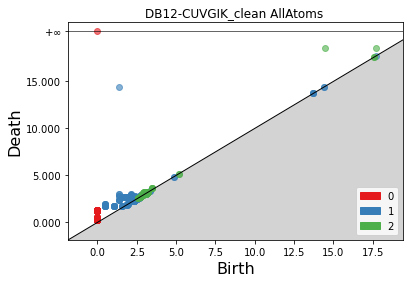

In [40]:

gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [41]:
fName="DB12-CUVGIK_clean.cif"
tittxt=f"{fName[:-4]} Nitrogen Topology "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/N/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

interactive(children=(FloatSlider(value=1.0, description='Alpha:', max=10.0, readout_format='.4f', step=0.5), …

Text(0.5, 1.0, 'DB12-CUVGIK_clean Nitrogen Topology ')

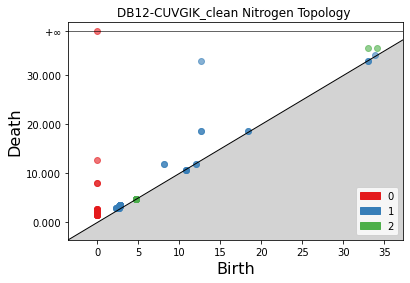

In [42]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [43]:
fName="DB12-CUVGIK_clean.cif"
tittxt=f"{fName[:-4]} Carbon Topology "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/C/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

interactive(children=(FloatSlider(value=1.0, description='Alpha:', max=10.0, readout_format='.4f', step=0.5), …

Text(0.5, 1.0, 'DB12-CUVGIK_clean Carbon Topology ')

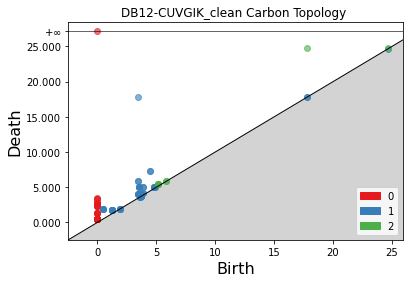

In [44]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [57]:
fName="DB0-m2_o13_o27_f0_pcu.sym.114.cif"
tittxt=f"bad MOF: {fName[:-4]} All Atoms Topology "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

interactive(children=(FloatSlider(value=1.0, description='Alpha:', max=10.0, readout_format='.4f', step=0.5), …

Text(0.5, 1.0, 'bad MOF: DB0-m2_o13_o27_f0_pcu.sym.114 All Atoms Topology ')

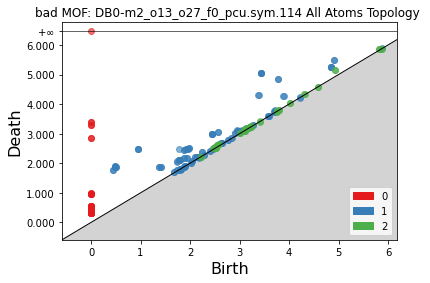

In [58]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [59]:
fName="DB0-m2_o13_o27_f0_pcu.sym.114.cif"
tittxt=f"bad MOF: {fName[:-4]} Nitrogen Topology "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/N/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

interactive(children=(FloatSlider(value=1.0, description='Alpha:', max=10.0, readout_format='.4f', step=0.5), …

Text(0.5, 1.0, 'bad MOF: DB0-m2_o13_o27_f0_pcu.sym.114 Nitrogen Topology ')

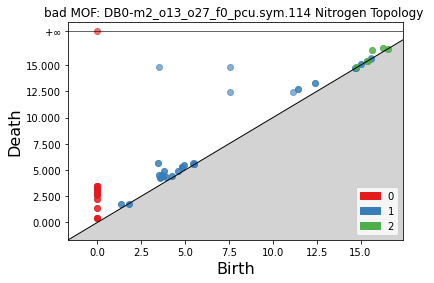

In [60]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [61]:
fName="DB0-m2_o13_o27_f0_pcu.sym.114.cif"
tittxt=f"bad MOF: {fName[:-4]} Carbon Topology "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/C/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

interactive(children=(FloatSlider(value=1.0, description='Alpha:', max=10.0, readout_format='.4f', step=0.5), …

Text(0.5, 1.0, 'bad MOF: DB0-m2_o13_o27_f0_pcu.sym.114 Carbon Topology ')

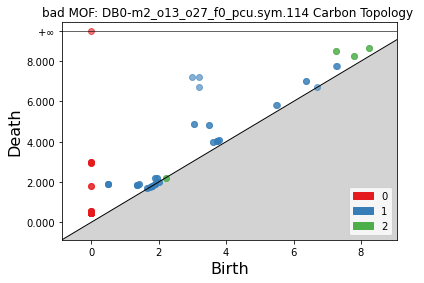

In [62]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [71]:
fName="DB12-BEXSEE_clean.cif"
tittxt=f"highCap MOF: {fName[:-4]} AllAtoms Topology "
dat=np.genfromtxt(f"{inDir}/cifPointClouds/total/{fName[:-3]}csv", dtype=float, delimiter=',', names=True)
st=genAlphaSlider(dat,titlePrefix=tittxt,step=.5)
dgm=st.persistence()

interactive(children=(FloatSlider(value=1.0, description='Alpha:', max=10.0, readout_format='.4f', step=0.5), …

Text(0.5, 1.0, 'highCap MOF: DB12-BEXSEE_clean AllAtoms Topology ')

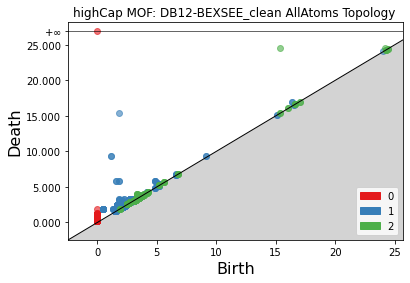

In [72]:
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.title(tittxt)

In [ ]:
def plot_diagrams(
    diagrams,
    plot_only=None,
    title=None,
    xy_range=None,
    labels=None,
    colormap="default",
    size=20,
    ax_color=np.array([0.0, 0.0, 0.0]),
    diagonal=True,
    lifetime=False,
    legend=True,
    show=False,
    ax=None,
    saveLoc=None
):
    """A helper function to plot persistence diagrams.

    Parameters
    ----------
    diagrams: ndarray (n_pairs, 2) or list of diagrams
        A diagram or list of diagrams. If diagram is a list of diagrams,
        then plot all on the same plot using different colors.
    plot_only: list of numeric
        If specified, an array of only the diagrams that should be plotted.
    title: string, default is None
        If title is defined, add it as title of the plot.
    xy_range: list of numeric [xmin, xmax, ymin, ymax]
        User provided range of axes. This is useful for comparing
        multiple persistence diagrams.
    labels: string or list of strings
        Legend labels for each diagram.
        If none are specified, we use H_0, H_1, H_2,... by default.
    colormap: string, default is 'default'
        Any of matplotlib color palettes.
        Some options are 'default', 'seaborn', 'sequential'.
        See all available styles with

        .. code:: python

            import matplotlib as mpl
            print(mpl.styles.available)

    size: numeric, default is 20
        Pixel size of each point plotted.
    ax_color: any valid matplotlib color type.
        See [https://matplotlib.org/api/colors_api.html](https://matplotlib.org/api/colors_api.html) for complete API.
    diagonal: bool, default is True
        Plot the diagonal x=y line.
    lifetime: bool, default is False. If True, diagonal is turned to False.
        Plot life time of each point instead of birth and death.
        Essentially, visualize (x, y-x).
    legend: bool, default is True
        If true, show the legend.
    show: bool, default is False
        Call plt.show() after plotting. If you are using self.plot() as part
        of a subplot, set show=False and call plt.show() only once at the end.
    """

    ax = ax or plt.gca()
    plt.style.use(colormap)

    xlabel, ylabel = "Birth", "Death"

    if not isinstance(diagrams, list):
        # Must have diagrams as a list for processing downstream
        diagrams = [diagrams]

    if labels is None:
        # Provide default labels for diagrams if using self.dgm_
        labels = ["$H_{{{}}}$".format(i) for i , _ in enumerate(diagrams)]

    if plot_only:
        diagrams = [diagrams[i] for i in plot_only]
        labels = [labels[i] for i in plot_only]

    if not isinstance(labels, list):
        labels = [labels] * len(diagrams)

    # Construct copy with proper type of each diagram
    # so we can freely edit them.
    diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]

    # find min and max of all visible diagrams
    concat_dgms = np.concatenate(diagrams).flatten()
    has_inf = np.any(np.isinf(concat_dgms))
    finite_dgms = concat_dgms[np.isfinite(concat_dgms)]

    # clever bounding boxes of the diagram
    if not xy_range:
        # define bounds of diagram
        ax_min, ax_max = np.min(finite_dgms), np.max(finite_dgms)
        x_r = ax_max - ax_min

        # Give plot a nice buffer on all sides.
        # ax_range=0 when only one point,
        buffer = 1 if xy_range == 0 else x_r / 5

        x_down = ax_min - buffer / 2
        x_up = ax_max + buffer

        y_down, y_up = x_down, x_up
    else:
        x_down, x_up, y_down, y_up = xy_range

    yr = y_up - y_down

    if lifetime:

        # Don't plot landscape and diagonal at the same time.
        diagonal = False

        # reset y axis so it doesn't go much below zero
        y_down = -yr * 0.05
        y_up = y_down + yr

        # set custom ylabel
        ylabel = "Lifetime"

        # set diagrams to be (x, y-x)
        for dgm in diagrams:
            dgm[:, 1] -= dgm[:, 0]

        # plot horizon line
        ax.plot([x_down, x_up], [0, 0], c=ax_color)

    # Plot diagonal
    if diagonal:
        ax.plot([x_down, x_up], [x_down, x_up], "--", c=ax_color)

    # Plot inf line
    if has_inf:
        # put inf line slightly below top
        b_inf = y_down + yr * 0.95
        ax.plot([x_down, x_up], [b_inf, b_inf], "--", c="k", label=r"$\infty$")

        # convert each inf in each diagram with b_inf
        for dgm in diagrams:
            dgm[np.isinf(dgm)] = b_inf

    # Plot each diagram
    for dgm, label in zip(diagrams, labels):

        # plot persistence pairs
        ax.scatter(dgm[:, 0], dgm[:, 1], size, label=label, edgecolor="none")

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    ax.set_xlim([x_down, x_up])
    ax.set_ylim([y_down, y_up])
    ax.set_aspect('equal', 'box')

    if title is not None:
        ax.set_title(title)

    if legend is True:
        ax.legend(loc="lower right")

    if saveLoc and type(saveLoc)==str:
        #ax.set_title(saveLoc[len(saveLoc)-saveLoc[::-1].find("\\")::saveLoc.find(".")] + ' espDist')
        plt.savefig(f'{saveLoc}',dpi=300,bbox_inches='tight')

    if show is True:
        plt.show()
